### Задание 10. Машинный перевод. Модель seq2seq и механизм внимания

In [1]:
import numpy as np

import re
from time import time

import torch
from torch import nn

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 41
MAX_LEN = 20
BATCH_SIZE = 128

In [3]:
def preprocess_sentence(w):
    w = w.lower().strip()
    w = re.sub('([?.!,;])', r' \1 ', w)
    w = re.sub("[^a-zA-Zа-яА-ЯёЁÁáÓóÉéýи́ы́э́ю́я́?.!,;']+", ' ', w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    
    return w

In [4]:
with open('rus.txt', 'r', encoding='utf-8') as f:
    lines = f.read().strip().split('\n')
    
word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines]

y_lang, x_lang = zip(*word_pairs)

In [5]:
len(x_lang), len(y_lang)

(479223, 479223)

In [6]:
x_lang[:4]

('<start> марш ! <end>',
 '<start> иди . <end>',
 '<start> идите . <end>',
 '<start> здравствуйте . <end>')

In [7]:
y_lang[:4]

('<start> go . <end>',
 '<start> go . <end>',
 '<start> go . <end>',
 '<start> hi . <end>')

In [8]:
def get_vocabs(lang):
    corpus = ' '.join(w for w in lang)
    vocab = set(corpus.split())
    char2idx = {w: i for i, w in enumerate(vocab, 1)}
    idx2char = {i: w for w, i in char2idx.items()}
    
    return char2idx, idx2char, len(vocab) + 1

In [9]:
x_char2idx, x_idx2char, x_vocab_size = get_vocabs(x_lang)
y_char2idx, y_idx2char, y_vocab_size = get_vocabs(y_lang)

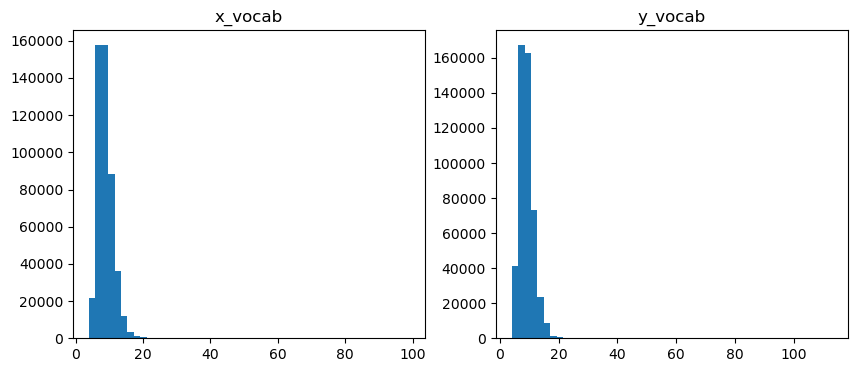

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist([len(x.split()) for x in x_lang], bins=50)
plt.title('x_vocab')

plt.subplot(1, 2, 2)
plt.hist([len(y.split()) for y in y_lang], bins=50)
plt.title('y_vocab')

plt.show()

In [11]:
def text_to_seq(text, vocab):
    seq = []
    for token in text.split():
        if token in vocab:
            seq.append(vocab[token])
    padding = [0] * (MAX_LEN - len(seq))
    return seq[:MAX_LEN] + padding

In [12]:
X = np.array([text_to_seq(text, x_char2idx) for text in x_lang])
Y = np.array([text_to_seq(text, y_char2idx) for text in y_lang])

In [13]:
class DataWrapper(torch.utils.data.Dataset):
    def __init__(self, data, target):
        self.data = torch.from_numpy(data)
        self.target = torch.from_numpy(target)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [14]:
torch.random.manual_seed(RANDOM_STATE)

dataset = DataWrapper(X, Y)

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True)

In [15]:
class AttentionLayer(nn.Module):
    def __init__(self, units=32, hidden_size=512):
        super().__init__()
        
        self.W1 = nn.Linear(hidden_size, units)
        self.W2 = nn.Linear(2 * hidden_size, units)
        self.V = nn.Linear(units, 1)
        
    def forward(self, dec_hidden, enc_output):
        score = self.V(torch.tanh(self.W1(dec_hidden) + self.W2(enc_output)))
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1, keepdim=True)
        
        return context_vector

In [16]:
class Encoder(nn.Module):
    def __init__(self, embed_dim=256, hidden_size=512):
        super().__init__()
        
        self.embedding = nn.Embedding(x_vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x):
        x = self.embedding(x)
        output, state = self.gru(x)
        state, _ = torch.max(state, dim=0, keepdim=True)
        
        return output, state

In [17]:
class Decoder(nn.Module):
    def __init__(self, attention_units=32, embed_dim=256, hidden_size=512):
        super().__init__()
        
        self.attention = AttentionLayer(units=attention_units, hidden_size=hidden_size)
        self.embedding = nn.Embedding(y_vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim + 2 * hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, y_vocab_size)
        
    def forward(self, x, state, enc_output):
        state = state.permute(1, 0, 2)
        context_vector = self.attention(state, enc_output)
        x = self.embedding(x)
        x = torch.cat((context_vector, x), dim=-1)
        output, state = self.gru(x)
        output = torch.squeeze(output)
        output = self.fc(output)
        
        return output, state

In [27]:
def train_nn(epochs=5, embed_dim=256, hidden_dim=512, lr=1e-3):
    
    torch.random.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True

    encoder = Encoder(embed_dim=embed_dim, hidden_size=hidden_dim)
    decoder = Decoder(embed_dim=embed_dim, hidden_size=hidden_dim)

    param_groups = [
    {'params': encoder.parameters(), 'lr': lr},
    {'params': decoder.parameters(), 'lr': lr}
    ]
    
    optimizer = torch.optim.Adam(param_groups)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        
        start_time = time()
        batch_losses = np.array([])
        
        for inputs, targets in loader:
            loss = 0
            inputs, targets = inputs, targets
            optimizer.zero_grad()
            enc_output, enc_hidden = encoder(inputs)
            
            dec_input = torch.IntTensor([y_char2idx['<start>']] * len(inputs)).reshape(-1, 1)
            dec_hidden = enc_hidden.detach().clone().requires_grad_(True)
            
            for t in range(1, MAX_LEN):
                preds, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                loss += criterion(preds, targets[:, t].type(torch.LongTensor))

                dec_input = targets[:, t].reshape(-1, 1)
            
            loss.backward()
            optimizer.step()

            batch_losses = np.append(batch_losses, loss.item() / t)

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Loss: {batch_losses.mean():.3f}. ' \
              f'Time: {round(time() - start_time)} с.')

    print('Обучение завершено')
    
    return encoder, decoder

In [ ]:
enc_model, dec_model = train_nn(epochs=7)

In [ ]:
def translate(ru_text):
    with torch.no_grad():
        en_text = ''

        ru_text_processed = preprocess_sentence(ru_text)
        
        ru_text_idx = torch.IntTensor([text_to_seq(ru_text_processed, x_char2idx)]).reshape(1, -1)
        
        enc_output, enc_hidden = enc_model(ru_text_idx)

        dec_hidden = enc_hidden.detach().clone()
        
        dec_input = torch.IntTensor([y_char2idx['<start>']]).reshape(1, -1)

        for t in range(MAX_LEN):
            translated, dec_hidden = dec_model(dec_input, dec_hidden, enc_output)

            en_idx = torch.argmax(translated)
            
            en_char = y_idx2char[en_idx.item()]
            
            if en_char == '<end>':
                break

            en_text = en_text + en_char + ' '

            dec_input = en_idx.reshape(1, -1)

    print(f'Текст на русском:\t\t{ru_text}\n'
          f'Перевод на английский:\t{en_text}')